# Experiment 2: CIFAR-100 Clean – Activation Function Comparison

This notebook compares 8 activation functions (ReLU, LeakyReLU, GELU, Swish, Mish, original PASA, BayesianPASA) with LayerNorm and includes the flagship BayesianPASA + Bayesian R‑LayerNorm combination on clean CIFAR-100. It uses the same CNN architecture as before but adapted for 100 classes.

Using device: cuda
GPU: Tesla T4
VRAM: 15.6 GB

========== Training relu ==========


100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Epoch   1/50 | Train Acc: 7.74% | Test Acc: 12.15%
Epoch   2/50 | Train Acc: 15.87% | Test Acc: 19.28%
Epoch   3/50 | Train Acc: 23.63% | Test Acc: 29.00%
Epoch   4/50 | Train Acc: 32.35% | Test Acc: 33.11%
Epoch   5/50 | Train Acc: 40.33% | Test Acc: 40.92%
Epoch   6/50 | Train Acc: 46.20% | Test Acc: 44.63%
Epoch   7/50 | Train Acc: 50.25% | Test Acc: 48.38%
Epoch   8/50 | Train Acc: 52.86% | Test Acc: 49.46%
Epoch   9/50 | Train Acc: 54.98% | Test Acc: 47.43%
Epoch  10/50 | Train Acc: 56.55% | Test Acc: 49.54%
Epoch  11/50 | Train Acc: 58.76% | Test Acc: 53.00%
Epoch  12/50 | Train Acc: 59.97% | Test Acc: 49.33%
Epoch  13/50 | Train Acc: 61.51% | Test Acc: 54.80%
Epoch  14/50 | Train Acc: 62.68% | Test Acc: 54.56%
Epoch  15/50 | Train Acc: 63.97% | Test Acc: 55.97%
Epoch  16/50 | Train Acc: 64.72% | Test Acc: 54.96%
Epoch  17/50 | Train Acc: 65.76% | Test Acc: 55.99%
Epoch  18/50 | Train Acc: 67.01% | Test Acc: 54.60%
Epoch  19/50 | Train Acc: 68.09% | Test Acc: 59.71%
Epoch  20/50 

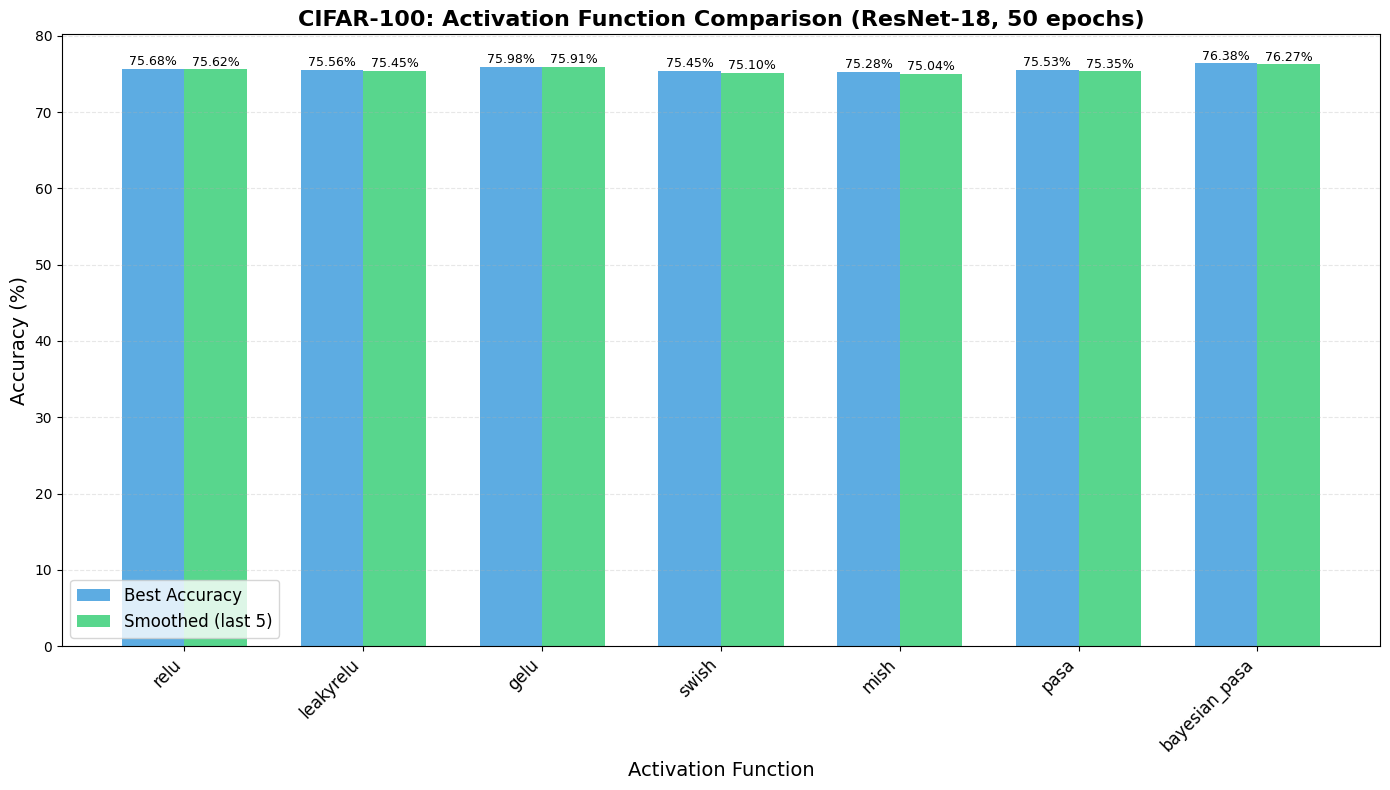


📊 CIFAR-100 Activation Function Ranking
Rank   Activation        Best Accuracy
--------------------------------------------------------------------------------
1      bayesian_pasa             76.38%
2      gelu                      75.98%
3      relu                      75.68%
4      leakyrelu                 75.56%
5      pasa                      75.53%
6      swish                     75.45%
7      mish                      75.28%


In [1]:
# -*- coding: utf-8 -*-
"""Experiment1_CIFAR100_Clean.ipynb

Automatically generated for Colab T4 GPU.
"""

# Install required packages
!pip install torch torchvision tqdm matplotlib seaborn --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
import random
import gc
from copy import deepcopy

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# ----------------------------------------------------------------------------
# 1. Activation Functions
# ----------------------------------------------------------------------------

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = beta
    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

class PASA(nn.Module):
    """Original PASA – stable version with running averages and learnable temperature."""
    def __init__(self,
                 alpha0=1.0, alpha1=0.5, kappa=0.1,
                 tau=5.0, beta=1.0,
                 lambda1=0.5, mu1=0.0, tau_lin=2.0,
                 eps=1e-6, momentum=0.99,
                 temperature_init=1.0):
        super().__init__()
        self.alpha0 = nn.Parameter(torch.tensor(alpha0))
        self.alpha1 = nn.Parameter(torch.tensor(alpha1))
        self.kappa  = nn.Parameter(torch.tensor(kappa))
        self.tau_mix = nn.Parameter(torch.tensor(temperature_init))

        self.tau = tau
        self.beta = beta
        self.lambda1 = lambda1
        self.mu1 = mu1
        self.tau_lin = tau_lin
        self.eps = eps
        self.momentum = momentum

        self.register_buffer('running_absmean', torch.tensor(0.5))
        self.register_buffer('running_noise_var', torch.tensor(1.0))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x, return_weights=False):
        if self.training:
            with torch.no_grad():
                batch_absmean = x.abs().mean()
                batch_var = x.var(unbiased=False)
                if self.num_batches_tracked == 0:
                    self.running_absmean = batch_absmean
                    self.running_noise_var = batch_var
                else:
                    self.running_absmean = (self.momentum * self.running_absmean +
                                            (1 - self.momentum) * batch_absmean)
                    self.running_noise_var = (self.momentum * self.running_noise_var +
                                              (1 - self.momentum) * batch_var)
                self.num_batches_tracked += 1

        mu_abs = self.running_absmean
        sigma2 = self.running_noise_var.clamp(min=1e-2, max=1e2)
        log_sigma2 = torch.log(sigma2).clamp(min=-10, max=10)

        alpha = self.alpha0 + self.alpha1 * torch.tanh(self.kappa * mu_abs)
        S = torch.sigmoid(alpha * x)
        L = x / (1 + x.abs() / self.tau)
        sigma = torch.sqrt(sigma2)
        z = x / (self.beta * sigma * 1.41421356237)
        N = torch.tanh(1.4 * z)

        log_prior = torch.log(torch.tensor(1/3.0, device=x.device))
        E1 = -self.lambda1 * (x - self.mu1)**2 + log_prior
        E2 = -x.abs() / self.tau_lin + log_prior
        E3 = - (x**2) / (2 * sigma2) - log_sigma2 + log_prior

        w = torch.softmax(torch.stack([E1, E2, E3], dim=-1) / self.tau_mix, dim=-1)

        out = w[..., 0] * S + w[..., 1] * L + w[..., 2] * N
        if return_weights:
            return out, w
        return out

class BayesianPASA(nn.Module):
    """Bayesian PASA with ψ‑function and variational evidence."""
    def __init__(self,
                 alpha0=1.0, alpha1=0.5, kappa=0.1,
                 tau=5.0, beta=1.0,
                 lambda1=0.5, mu1=0.0, tau_lin=2.0,
                 lambda3=0.1,
                 eps=1e-6, momentum=0.99,
                 temperature_init=1.0):
        super().__init__()
        self.alpha0 = nn.Parameter(torch.tensor(alpha0))
        self.alpha1 = nn.Parameter(torch.tensor(alpha1))
        self.kappa  = nn.Parameter(torch.tensor(kappa))
        self.tau_mix = nn.Parameter(torch.tensor(temperature_init))

        self.tau = tau
        self.beta = beta
        self.lambda1 = lambda1
        self.mu1 = mu1
        self.tau_lin = tau_lin
        self.lambda3 = lambda3
        self.eps = eps
        self.momentum = momentum

        self.register_buffer('running_absmean', torch.tensor(0.5))
        self.register_buffer('running_noise_var', torch.tensor(1.0))
        self.register_buffer('running_local_entropy', torch.tensor(1.0))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def psi(self, t):
        return torch.log1p(t) - t / (1 + t)

    def forward(self, x, return_weights=False):
        B, C, H, W = x.shape

        if self.training:
            with torch.no_grad():
                batch_absmean = x.abs().mean()
                batch_var = x.var(unbiased=False)

                x_padded = F.pad(x, (1,1,1,1), mode='reflect')
                local_mean = F.avg_pool2d(x_padded, kernel_size=3, stride=1)
                local_var = F.avg_pool2d(x_padded**2, kernel_size=3, stride=1) - local_mean**2
                local_entropy = local_var.mean(dim=[1,2,3]).mean()

                if self.num_batches_tracked == 0:
                    self.running_absmean = batch_absmean
                    self.running_noise_var = batch_var
                    self.running_local_entropy = local_entropy
                else:
                    self.running_absmean = (self.momentum * self.running_absmean +
                                            (1 - self.momentum) * batch_absmean)
                    self.running_noise_var = (self.momentum * self.running_noise_var +
                                              (1 - self.momentum) * batch_var)
                    self.running_local_entropy = (self.momentum * self.running_local_entropy +
                                                  (1 - self.momentum) * local_entropy)
                self.num_batches_tracked += 1

        mu_abs = self.running_absmean
        sigma2 = self.running_noise_var.clamp(min=1e-2, max=1e2)
        log_sigma2 = torch.log(sigma2).clamp(min=-10, max=10)
        local_E = self.running_local_entropy.clamp(min=1e-2)

        alpha_slope = self.alpha0 + self.alpha1 * torch.tanh(self.kappa * self.psi(self.lambda3 * local_E))
        S = torch.sigmoid(alpha_slope * x)
        L = x / (1 + x.abs() / self.tau)
        sigma_eff = torch.sqrt(sigma2) * torch.exp(0.5 * self.psi(self.lambda3 * local_E))
        z = x / (self.beta * sigma_eff * 1.41421356237)
        N = torch.tanh(1.4 * z)

        log_prior = torch.log(torch.tensor(1/3.0, device=x.device))
        E1 = -0.5 * self.lambda1 * (x - self.mu1)**2 + log_prior
        E2 = -x.abs() / self.tau_lin + log_prior
        E3 = -0.5 * (x**2) / sigma2 - 0.5 * log_sigma2 - 0.5 * self.psi(self.lambda3 * local_E) + log_prior

        w = torch.softmax(torch.stack([E1, E2, E3], dim=-1) / self.tau_mix, dim=-1)

        out = w[..., 0] * S + w[..., 1] * L + w[..., 2] * N
        if return_weights:
            return out, w
        return out

# ----------------------------------------------------------------------------
# 2. Normalization Layers
# ----------------------------------------------------------------------------

class StandardLayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def forward(self, x):
        mean = x.mean(dim=[2,3], keepdim=True)
        var = x.var(dim=[2,3], keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight * x_norm + self.bias

class BayesianRLayerNorm(nn.Module):
    def __init__(self, num_features, lambda_init=0.01, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.lambda_param = nn.Parameter(torch.tensor(lambda_init))
        self.weight = nn.Parameter(torch.ones(1, num_features, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, num_features, 1, 1))

    def psi(self, t):
        return torch.log1p(t) - t / (1 + t)

    def forward(self, x, return_uncertainty=False):
        B, C, H, W = x.shape
        mean = x.mean(dim=[2,3], keepdim=True)
        var = x.var(dim=[2,3], keepdim=True, unbiased=False)
        std = torch.sqrt(var + self.eps)

        x_padded = F.pad(x, (1,1,1,1), mode='reflect')
        local_means = F.avg_pool2d(x_padded, kernel_size=3, stride=1)
        local_vars = F.avg_pool2d(x_padded**2, kernel_size=3, stride=1) - local_means**2
        local_vars = local_vars.clamp(min=0)
        noise_estimate = local_vars.mean(dim=[2,3], keepdim=True)

        lambda_safe = self.lambda_param.clamp(1e-3, 1.0)
        lambdaE = lambda_safe * noise_estimate / (var + self.eps)
        psi_term = self.psi(lambdaE)

        effective_std = std * torch.exp(0.5 * psi_term)
        normalized = (x - mean) / (effective_std + self.eps)
        output = self.weight * normalized + self.bias

        if return_uncertainty:
            uncertainty = 1.0 / (effective_std**2 + self.eps)
            return output, uncertainty
        return output

# ----------------------------------------------------------------------------
# 3. ResNet-18 Model for CIFAR-100
# ----------------------------------------------------------------------------

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, activation='relu'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.activation = activation

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def _get_activation(self):
        if self.activation == 'relu':
            return F.relu
        elif self.activation == 'gelu':
            return F.gelu
        elif self.activation == 'swish':
            return lambda x: x * torch.sigmoid(x)
        elif self.activation == 'mish':
            return lambda x: x * torch.tanh(F.softplus(x))
        else:
            return F.relu

    def forward(self, x):
        act = self._get_activation()
        out = act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = act(out)
        return out

class ResNet18_CIFAR100(nn.Module):
    def __init__(self, activation='relu', num_classes=100):
        super(ResNet18_CIFAR100, self).__init__()
        self.in_planes = 64
        self.activation = activation

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride, activation=self.activation))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def _get_activation(self):
        if self.activation == 'relu':
            return F.relu
        elif self.activation == 'gelu':
            return F.gelu
        elif self.activation == 'swish':
            return lambda x: x * torch.sigmoid(x)
        elif self.activation == 'mish':
            return lambda x: x * torch.tanh(F.softplus(x))
        else:
            return F.relu

    def forward(self, x):
        act = self._get_activation()
        out = act(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ----------------------------------------------------------------------------
# 4. Data Loaders for CIFAR-100 (clean)
# ----------------------------------------------------------------------------

def get_cifar100_loaders(batch_size=128):
    """Return train and test loaders for clean CIFAR-100."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)),
    ])

    trainset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    testset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                             num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    return trainloader, testloader



# ============================================================================
# 5. TRAINING FUNCTION (ONLY ONE - DELETE THE OTHER)
# ============================================================================

def run_experiment(activation, num_epochs=50, lr=0.1):
    """
    Train and evaluate ResNet-18 with given activation on CIFAR-100.
    Returns: best test accuracy, smoothed accuracy (avg of last 5 epochs)
    """
    print(f"\n========== Training {activation} ==========")

    # Create model
    model = ResNet18_CIFAR100(activation=activation, num_classes=100).to(device)

    # Data loaders
    trainloader, testloader = get_cifar100_loaders(batch_size=128)

    # Optimizer, scheduler, loss
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_model_state = None
    test_accuracies = []  # Store all test accuracies for smoothing

    for epoch in range(1, num_epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_acc = 100. * correct / total

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        test_accuracies.append(test_acc)
        scheduler.step()

        print(f"Epoch {epoch:3d}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            best_model_state = deepcopy(model.state_dict())

    # Calculate smoothed accuracy (average of last 5 epochs)
    last_5_acc = sum(test_accuracies[-5:]) / 5

    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Smoothed Accuracy (last 5 epochs): {last_5_acc:.2f}%")

    return best_acc, last_5_acc, best_model_state


# ============================================================================
# 6. RUN EXPERIMENTS & VISUALIZE (ALL IN ONE CELL)
# ============================================================================

activations = ['relu', 'leakyrelu', 'gelu', 'swish', 'mish', 'pasa', 'bayesian_pasa']
results = {}

for act in activations:
    best_acc, smoothed_acc, model_state = run_experiment(act, num_epochs=50, lr=0.1)
    results[act] = {
        'best': best_acc,
        'smoothed': smoothed_acc
    }
    torch.cuda.empty_cache()
    gc.collect()

# Print comparison
print("\n" + "="*70)
print("CIFAR-100 Test Accuracies (ResNet-18, 50 epochs)")
print("="*70)
print(f"{'Activation':15s} {'Best':>10s} {'Smoothed (last 5)':>20s}")
print("-"*70)
for act in activations:
    print(f"{act:15s} {results[act]['best']:10.2f}% {results[act]['smoothed']:20.2f}%")

# ============================================================================
# 7. VISUALIZATION (NOW results IS DEFINED)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# Prepare data
activations = list(results.keys())
best_accs = [results[act]['best'] for act in activations]
smoothed_accs = [results[act]['smoothed'] for act in activations]

# Create figure
plt.figure(figsize=(14, 8))
x = np.arange(len(activations))
width = 0.35

bars1 = plt.bar(x - width/2, best_accs, width, label='Best Accuracy', color='#3498db', alpha=0.8)
bars2 = plt.bar(x + width/2, smoothed_accs, width, label='Smoothed (last 5)', color='#2ecc71', alpha=0.8)

plt.xlabel('Activation Function', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('CIFAR-100: Activation Function Comparison (ResNet-18, 50 epochs)', fontsize=16, fontweight='bold')
plt.xticks(x, activations, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('cifar100_activation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print ranking
print("\n" + "="*80)
print("📊 CIFAR-100 Activation Function Ranking")
print("="*80)
print(f"{'Rank':<6} {'Activation':<15} {'Best Accuracy':>15}")
print("-"*80)
sorted_results = sorted(results.items(), key=lambda x: x[1]['best'], reverse=True)
for rank, (act, acc_dict) in enumerate(sorted_results, 1):
    print(f"{rank:<6} {act:<15} {acc_dict['best']:>15.2f}%")
print("="*80)